## Fine-tuning tutorial for Evo2: Adapt the 1b evo2 checkpoint for your hardware
Deploy tutorial on brev.dev:
[![ Click here to deploy.](https://brev-assets.s3.us-west-1.amazonaws.com/nv-lb-dark.svg)](https://console.brev.dev/launchable/deploy?launchableID=env-2uGqijcTiNxv3V8LZJxXAa7KlKC)

### Background and motivation
To motivate this tutorial, we have noticed that the public
evo2 checkpoint in hugging face for the 1b model is sensitive to `--fp8` status in training, the zero shot inference
task, as demonstrated in the zero shot BRCA-1 notebook, produces near random AUCs if you do not use `--fp8`. 
If you want to infer or score new data, you need FP8 enabled since it was trained that way. Interestingly the `7b` checkpoint does not suffer from this
limitation and seems robust to FP8 being activated or not. The consequence of this is that if you have older GPUs with
a compute capability less than 8.9, which do not support FP8, then the output that you get from scoring sequences with
sensitive checkpoints may not be biologically meaningful. 

We plan on making
a `1b` parameter evo2 checkpoint available soon that has been fine-tuned to be robust to FP8 or BF16 inference in bionemo
on NGC, but in the meantime this notebook tutorial outlines the steps for fine-tuning. The only difference between this
notebook and what we did in production was to run these steps on more data on a slurm cluster to increase the global
batch size. That said, if you run this for enough steps to get loss on the 1b checkpoint to the 1.08 range, you should 
have good luck with downstream sequence scoring tasks. 

### Requirements

This is a tutorial demonstrating how you can fine-tune Evo2 on new data and/or hardware. The tutorial should take 
slightly under 1 hour to run on an RTX A6000 in bf16 precision.

As configured, this tutorial requires an NVIDIA GPU with approximately 45GB of ram. If you have multiple GPUs with less
memory, or you are having trouble with CUDA OOM at the training step below, try reducing the `--micro-batch-size` and/or
increasing the number of `--devices [int]` to match your setup and also setting `--tensor-parallel-size [int]` to
the number of devices. This should split up most of the model evenly between your devices, which will require much less
memory. When we train the 1b model in practice we typically have the micro batch size set to 8, and run without model 
parallelism on available devices to achieve the largest possible global batch size.

In [1]:
import os


# This variable should be used in the notebooks to run a subset of the model layers or a smaller model/dataset
FAST_CI_MODE: bool = bool(int(os.environ.get("FAST_CI_MODE", "0")))
# Clean up any prior runs
CLEANUP: bool = False
if CLEANUP:
    !rm -rf preprocessed_data
    !rm -rf preatraining_demo
    !rm -rf pretraining_demo
    !rm -rf evo2_1b_bf16_mbridge
    !rm -rf training_data_config.yaml
    !rm -rf preprocess_config.yaml
    !rm -f chr20.fa.gz
    !rm -f chr21.fa.gz
    !rm -f chr22.fa.gz
    !rm -f chr20_21_22.fa

### Setup training data
Evo2 uses megatron style datasets behind the scenes with advanced support for randomly indexing into documents, and
packing documents together into batches at scale. The file-formats backing these datasets is not a standard biological
format like fasta for representing genomes. First we show how you can start from a fasta file and preprocess them into
the required data format for downstream handling. High level the steps are as follows:
1. Acquire fasta files locally, ideally in some shared cluster storage
2. Write a config script defining how you want the processed files to be generated from the fasta files. This is where
  you specify top level train/validation/test splitting decisions.
3. Call the actual `preprocess_evo2` script to generate the results.

The next 4 cells go through this process on a set of smaller human chromosomes. At least 3 fasta records need to be present,
one for the train, validation, and test split.

In [2]:
%%capture
import os

from bionemo.core.utils.subprocess_utils import run_subprocess_safely


concat_path = "chr20_21_22.fa"
if not os.path.exists(concat_path):
    !wget https://hgdownload.soe.ucsc.edu/goldenpath/hg38/chromosomes/chr20.fa.gz
    !wget https://hgdownload.soe.ucsc.edu/goldenpath/hg38/chromosomes/chr21.fa.gz
    !wget https://hgdownload.soe.ucsc.edu/goldenpath/hg38/chromosomes/chr22.fa.gz
    !zcat chr20.fa.gz > chr20.fa
    !zcat chr21.fa.gz > chr21.fa
    !zcat chr22.fa.gz > chr22.fa
    !cat chr20.fa chr21.fa chr22.fa > chr20_21_22.fa

In [3]:
from bionemo.evo2.data.dataset_tokenizer import (
    DEFAULT_HF_TOKENIZER_MODEL_PATH,  # use the 512 size for historical reasons
)


full_fasta_path = os.path.abspath(concat_path)
output_dir = os.path.abspath("preprocessed_data")


output_yaml = f"""
- datapaths: ["{full_fasta_path}"]
  output_dir: "{output_dir}"
  output_prefix: chr20_21_22_uint8_distinct
  train_split: 0.9
  valid_split: 0.05
  test_split: 0.05
  overwrite: True
  embed_reverse_complement: true
  random_reverse_complement: 0.0
  random_lineage_dropout: 0.0
  include_sequence_id: false
  transcribe: "back_transcribe"
  force_uppercase: false
  indexed_dataset_dtype: "uint8"
  hf_tokenizer_model_path: {DEFAULT_HF_TOKENIZER_MODEL_PATH}
  pretrained_tokenizer_model: null
  special_tokens: null
  fast_hf_tokenizer: true
  append_eod: true
  enforce_sample_length: null
  ftfy: false
  workers: 1
  preproc_concurrency: 100000
  chunksize: 25
  drop_empty_sequences: true
  nnn_filter: false  # If you split your fasta on NNN (in human these are contigs), then you should set this to true.
  seed: 12342  # Not relevant because we are not using random reverse complement or lineage dropout.
"""
with open("preprocess_config.yaml", "w") as f:
    print(output_yaml, file=f)

/usr/local/lib/python3.12/dist-packages/torch/cuda/__init__.py:65: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/workspaces/bionemo-framework/bionemo-recipes/recipes/evo2_megatron/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.12/dist-packages/torch/library.py:356: UserWarning: Warning only once for all operators,  other operators may also be overridden.
  Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: flash_attn::_flash_attn_backward(Tensor dout, Tensor q, Tensor k, Tensor v, Tensor out, Tensor softmax_lse, Tensor(a6!

In [4]:
%%capture
!preprocess_evo2 --config preprocess_config.yaml

In [5]:
# There should be a collection of bin/idx files created in the preprocessed_data directory.
!ls -lh preprocessed_data/

total 309M
drwxr-xr-x 3 ubuntu ubuntu 4.0K Jan 14 18:48 chr20_21_22_uint8_distinct_nucleotide_fast_tokenizer_256_test
-rw-r--r-- 1 ubuntu ubuntu  90M Jan 15 00:46 chr20_21_22_uint8_distinct_nucleotide_fast_tokenizer_256_test.bin
-rw-r--r-- 1 ubuntu ubuntu   82 Jan 15 00:48 chr20_21_22_uint8_distinct_nucleotide_fast_tokenizer_256_test.idx
drwxr-xr-x 3 ubuntu ubuntu 4.0K Jan 14 18:48 chr20_21_22_uint8_distinct_nucleotide_fast_tokenizer_256_train
-rw-r--r-- 1 ubuntu ubuntu 123M Jan 15 00:48 chr20_21_22_uint8_distinct_nucleotide_fast_tokenizer_256_train.bin
-rw-r--r-- 1 ubuntu ubuntu   82 Jan 15 00:48 chr20_21_22_uint8_distinct_nucleotide_fast_tokenizer_256_train.idx
drwxr-xr-x 3 ubuntu ubuntu 4.0K Jan 14 18:48 chr20_21_22_uint8_distinct_nucleotide_fast_tokenizer_256_val
-rw-r--r-- 1 ubuntu ubuntu  97M Jan 15 00:44 chr20_21_22_uint8_distinct_nucleotide_fast_tokenizer_256_val.bin
-rw-r--r-- 1 ubuntu ubuntu   82 Jan 15 00:48 chr20_21_22_uint8_distinct_nucleotide_fast_tokenizer_256_val.idx


### [Optional] specify or convert initial checkpoint
The main difference between pre-training and fine-tuning is whether or not you decide to start training the model with
weights from a prior training run. For this tutorial we want to tune a `1b` checkpoint that is known
(at the time of this writing) to be sensitive to GPU architecture so that it will work with your architecture.

We use `bionemo.core.data.load` to download pre-trained NeMo2 checkpoints from NGC. These checkpoints can be used
directly with the `train_evo2` command for fine-tuning.

**Note**: The `train_evo2` command produces MBridge format checkpoints that can be used directly with
`infer_evo2` or `predict_evo2` for inference - no conversion step is needed.

In [6]:
from pathlib import Path

from bionemo.core.data.load import load
from bionemo.evo2.data.dataset_tokenizer import (
    DEFAULT_HF_TOKENIZER_MODEL_PATH_512,  # use the 512 size for historical reasons
)


# Download the 1b BF16 checkpoint from NGC
# Available checkpoints: evo2/1b-8k-bf16:1.0, evo2/1b-8k:1.0, evo2/7b-8k:1.0, evo2/7b-1m:1.0
mbridge_ckpt_path = Path("evo2_1b_bf16_mbridge")

if not mbridge_ckpt_path.exists():
    nemo2_ckpt_path = load("evo2/1b-8k-bf16:1.0")
    mixed_precision_recipe = "bf16_mixed"  # also try bf16_with_fp8_current_scaling_mixed
    convert_ckpt_cmd = f"""evo2_convert_nemo2_to_mbridge \
        --nemo2-ckpt-dir {nemo2_ckpt_path} \
        --mbridge-ckpt-dir {mbridge_ckpt_path} \
        --model-size 1b \
        --mixed-precision-recipe {mixed_precision_recipe} \
        --seq-length 8192 \
        --tokenizer-path {DEFAULT_HF_TOKENIZER_MODEL_PATH_512} \
    """.rstrip()
    print(f"Running command: {convert_ckpt_cmd}")

    result = run_subprocess_safely(convert_ckpt_cmd)
    print(f"Downloaded checkpoint to: {nemo2_ckpt_path} and converted to mbridge format at {mbridge_ckpt_path}")

### Configure the training dataset
The next step is to configure your training dataset, in this case configuring the simple single-file example we output
two steps ago in this tutorial. 

In [7]:
from pathlib import Path


output_pfx = str(
    Path(os.path.abspath("preprocessed_data")) / "chr20_21_22_uint8_distinct_nucleotide_fast_tokenizer_256"
)
output_yaml = f"""
- dataset_prefix: {output_pfx}_train
  dataset_split: train
  dataset_weight: 1.0
- dataset_prefix: {output_pfx}_val
  dataset_split: validation
  dataset_weight: 1.0
- dataset_prefix: {output_pfx}_test
  dataset_split: test
  dataset_weight: 1.0
"""
with open("training_data_config.yaml", "w") as f:
    print(output_yaml, file=f)

This next cell takes approximately 25 minutes to run on an RTX A6000 with `MAX_STEPS=100`. Each step takes about 9.5 seconds with the 
following configuration, so you can budget a desired number of max steps to try.

In [15]:
%%capture
import torch


MAX_STEPS: int = 10 if FAST_CI_MODE else 100
val_check_interval = min(int(MAX_STEPS // 2), 50)
warmup_steps = min(MAX_STEPS, 100)
# For evo2 training and fine-tuning follow the same set of steps, so we use the same train_evo2 command.
#  the big difference is the --ckpt-dir argument which points to a pre-existing checkpoint from some other training run.

if FAST_CI_MODE:
    model_subset_option = (
        "--num-layers 4 --hybrid-override-pattern SDH* --activation-checkpoint-recompute-num-layers 2"
    )
else:
    # By default do 5 layers of activation checkpointing
    model_subset_option = "--activation-checkpoint-recompute-num-layers 5"
num_gpus = torch.cuda.device_count()
# The 1b model is configured in a way that you can not use TP, but you can use CP.
train_cmd = f"""torchrun --nproc_per_node={num_gpus} --no-python train_evo2 \
    -d training_data_config.yaml \
    --dataset-dir ./preprocessed_data \
    --result-dir pretraining_demo \
    --experiment-name evo2 \
    --context-parallel-size {num_gpus} \
    --model-size 1b \
    --seq-length 8192 \
    --micro-batch-size 1 \
    --global-batch-size 8 \
    --eval-iters 5 \
    --decay-steps 100000 --warmup-steps 10 \
    --hf-tokenizer-model-path {DEFAULT_HF_TOKENIZER_MODEL_PATH_512} \
    --eval-interval {val_check_interval} \
    --lr 0.000015 \
    --min-lr 0.0000149 \
    --warmup-steps {warmup_steps} \
    --max-steps {MAX_STEPS} \
    --finetune-ckpt-dir {mbridge_ckpt_path} \
    --clip-grad 250 \
    --wd 0.001 \
    --attention-dropout 0.01 \
    --hidden-dropout 0.01 \
    {model_subset_option}"""

print(f"Running command: {train_cmd}")

result = run_subprocess_safely(train_cmd)

In [16]:
if result["returncode"] != 0:
    print("================== STDOUT ==========================")
    print(result["stdout"])
    print("================== STDERR ==========================")
    print(result["stderr"])
    raise AssertionError("Training failed. See stdout and stderr above for more details.")

The plotting code is hidden in documentation for brevity. You can view the notebook on github, run it in jupyter-lab or launch the tutorial on brev.dev if you want to view the source.

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorboard.backend.event_processing.event_accumulator as event_accumulator


# Function to extract data from TensorBoard event files and convert to DataFrame
def tensorboard_to_dataframe(event_file):
    """Given a TensorBoard event file, return a pandas DataFrame with the training metrics."""
    # Load the event file
    ea = event_accumulator.EventAccumulator(
        event_file,
        size_guidance={
            event_accumulator.SCALARS: 0,  # 0 means load all
        },
    )
    ea.Reload()

    # Get list of all available tags
    tags = ea.Tags()["scalars"]

    # First, find the union of all steps
    all_steps = set()
    for tag in tags:
        events = ea.Scalars(tag)
        steps = [event.step for event in events]
        all_steps.update(steps)

    # Sort steps for proper ordering
    all_steps = sorted(all_steps)

    # Initialize the dataframe with steps
    df = pd.DataFrame({"step": all_steps})

    # Add each metric as a column
    for tag in tags:
        events = ea.Scalars(tag)
        # Create a dictionary mapping steps to values
        step_to_value = {event.step: event.value for event in events}
        # Add the values to the dataframe, using NaN for missing steps
        df[tag] = df["step"].map(step_to_value)

    return df


# Example of creating a multi-metric plot with seaborn
def plot_multiple_training_metrics(df, metrics_to_plot, figsize=(15, 10)):
    """Given a pandas DataFrame with the training metrics, plot the metrics."""
    n = len(metrics_to_plot)
    fig, axes = plt.subplots(n, 1, figsize=figsize, sharex=True)

    if n == 1:  # Handle the case of a single plot
        axes = [axes]

    sns.set_style("whitegrid")

    for i, metric in enumerate(metrics_to_plot):
        if metric in df.columns:
            sns.lineplot(x="step", y=metric, data=df, ax=axes[i], linewidth=2.5, errorbar="sd")
            axes[i].set_title(metric, fontsize=14)
            axes[i].set_ylabel("Value", fontsize=12)
    axes[-1].set_xlabel("Steps", fontsize=14)
    plt.tight_layout()
    plt.show()

The following figures show various training metrics per step.
* `reduced_train_loss` captures the training loss. On larger runs you want to see the loss drop to about 1.08 consistently
  for the 1b checkpoint.
* `lr` shows the learning rate schedule for training. Typically we do a linear warmup schedule followed by an cosine decay.
  this small notebook tutorial just goes through the initial warmup period.
* `grad_norm` shows the gradient norm of the full model. As the model fits the data better you should see this value drop
  down below 1.0 consistently. 
* `val_loss` shows the same kind of loss shown in `reduced_train_loss` but for a held-out set of validation samples. If you
  ever train the model a very long time and see this start to go up while the training loss continues to drop that's a sign
  of over-fitting. We have not yet seen this happen. Small fluctuations up and down are expected during training.

/tmp/ipykernel_3593112/2519380624.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tag] = df["step"].map(step_to_value)
/tmp/ipykernel_3593112/2519380624.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tag] = df["step"].map(step_to_value)
/tmp/ipykernel_3593112/2519380624.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

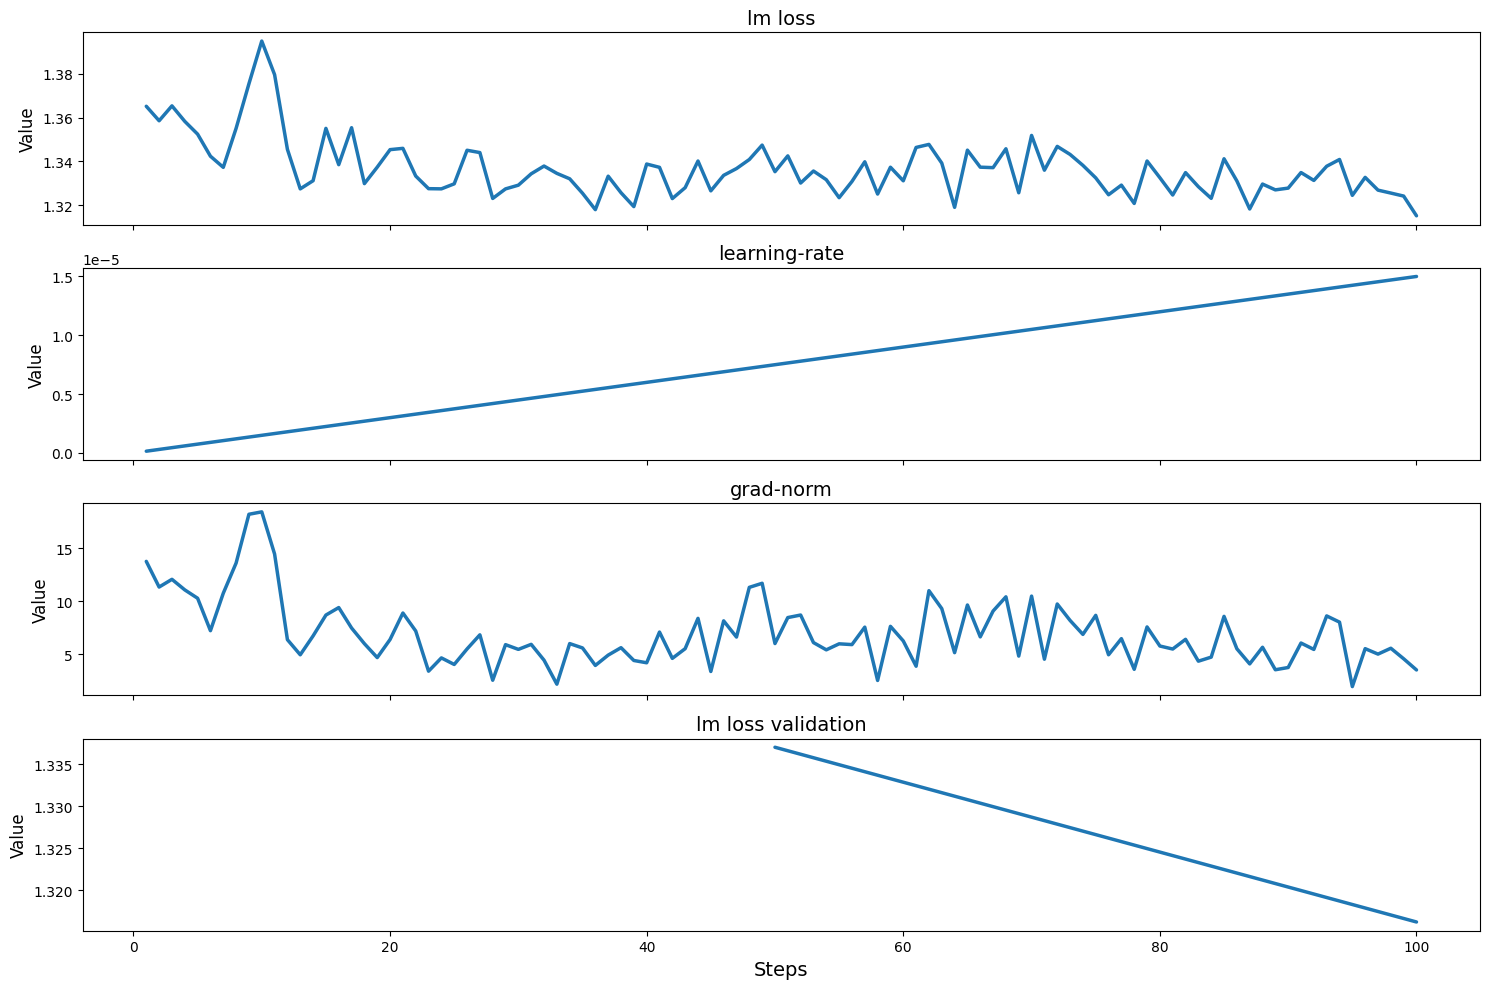

In [18]:
# Get the TensorBoard event file for the training run
log_dirs = !find pretraining_demo/evo2/tb_logs -name "events.out.tfevents*" | sort | tail -1
tf_event_file = log_dirs[0]

# Extract data from your event file
df = tensorboard_to_dataframe(tf_event_file)
# You can uncomment and modify this to plot multiple metrics once you see what's available
plot_multiple_training_metrics(df, ["lm loss", "learning-rate", "grad-norm", "lm loss validation"])

Now you have a fine-tuned checkpoint that you can use for inference. The `train_evo2` command produces
MBridge format checkpoints that work directly with the inference scripts.

**Option 1: Use `predict_evo2` for log-probability scoring**
```bash
predict_evo2 --ckpt-dir <checkpoint_dir> --input-fasta sequences.fa --output-dir results/
```

**Option 2: Use `infer_evo2` for text generation**
```bash
infer_evo2 --ckpt-dir <checkpoint_dir> --prompt "ATCGATCG" --max-new-tokens 100
```

The checkpoint directory path is displayed in the next cell. You can also use this checkpoint for further
fine-tuning by passing it to `--ckpt-dir` in another `train_evo2` run.

In our experience running this notebook for up to an hour on a single GPU is not sufficient to recover BF16 accuracy. We
have more details about what did work in the Next Steps section below.

In [19]:
from pathlib import Path


# The checkpoint directory contains all saved iterations
# The inference scripts automatically find the latest iteration
ckpt_dir = Path("pretraining_demo/evo2/checkpoints")
print(f"Checkpoint directory: {ckpt_dir.absolute()}")

# List available checkpoints
if ckpt_dir.exists():
    checkpoints = list(ckpt_dir.glob("iter_*"))
    print(f"\nAvailable checkpoints: {[c.name for c in sorted(checkpoints)]}")

print("\nYou can now run inference with:")
print(f"  infer_evo2 --ckpt-dir {ckpt_dir} --prompt 'ATCGATCG' --max-new-tokens 100")
print(f"  predict_evo2 --ckpt-dir {ckpt_dir} --input-fasta <your_fasta> --output-dir <output>")

Checkpoint directory: /workspaces/bionemo-framework/bionemo-recipes/recipes/evo2_megatron/examples/pretraining_demo/evo2/checkpoints

Available checkpoints: ['iter_0000050', 'iter_0000100']

You can now run inference with:
  infer_evo2 --ckpt-dir pretraining_demo/evo2/checkpoints --prompt 'ATCGATCG' --max-new-tokens 100
  predict_evo2 --ckpt-dir pretraining_demo/evo2/checkpoints --input-fasta <your_fasta> --output-dir <output>


### Next steps
On a small number of devices, or with the small demo fasta we provided in this tutorial, it's possible you are not at the needed
1.08 loss level to get good downstream accuracy out of this checkpoint. You can try increasing the `MAX_STEPS` parameter in the training cell,
or running a larger cluster with more GPUs. The following loss curve was generated with a global batch size of 256 at 8192 context or approximately
2 million tokens per step. With that configuration we see a good loss of 1.08 after approximately 100 steps. The following figure shows our
learning rate across the first 500 steps of fine-tuning with a global batch size of 256. Later on in this notebook we also show the slurm script
to replicate this on your cluster.


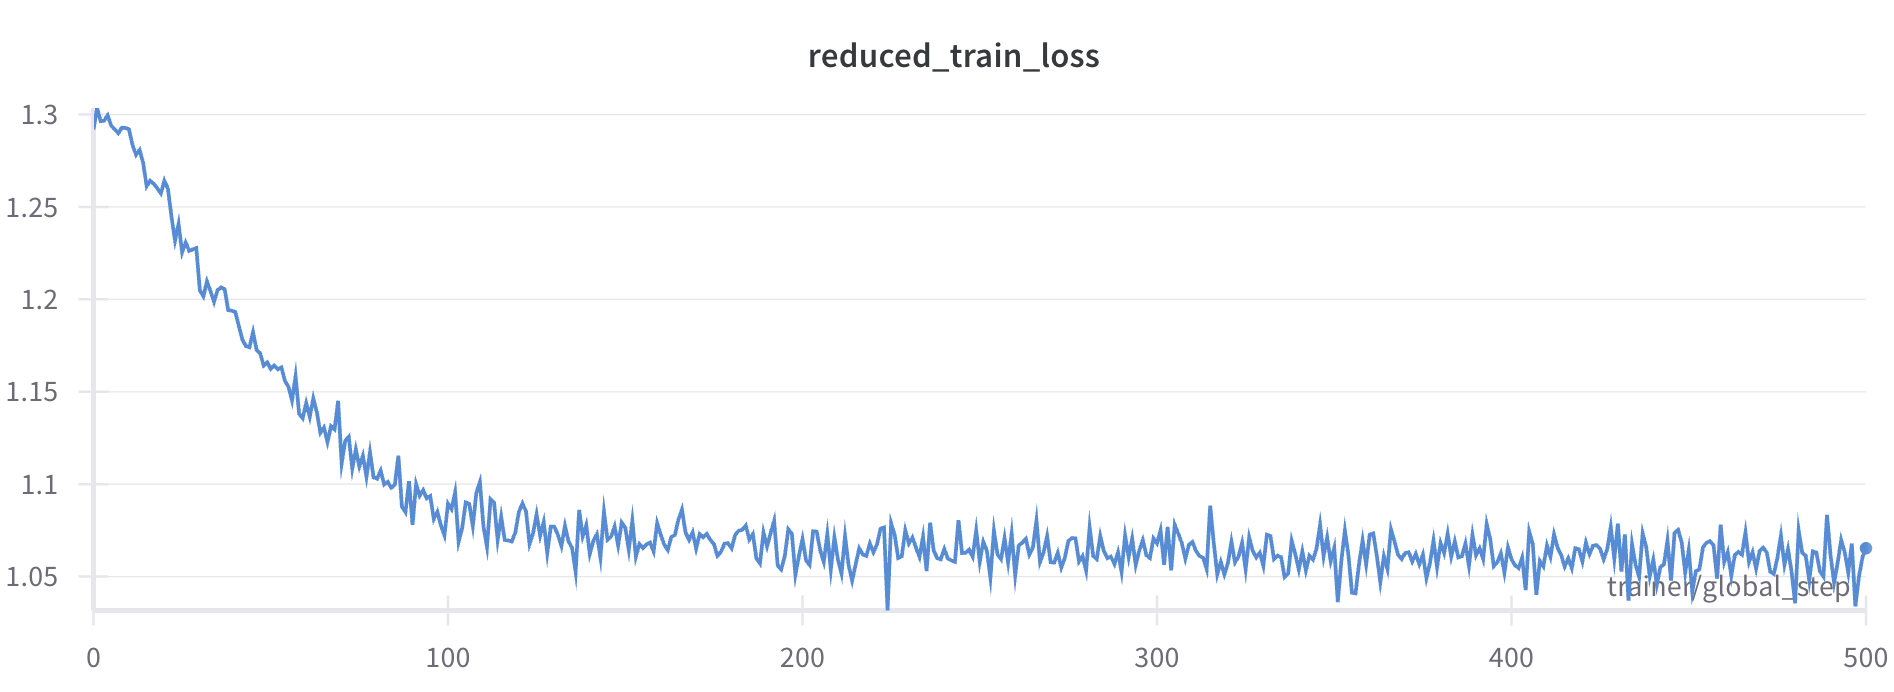

In [20]:
# Display the example loss curve from a larger training run
from IPython.display import Image, display


# Load and display the image
display(Image("../assets/1b_finetuning_train_curve_500_steps_256gbs.png", width=800))

#### How we fine-tuned the 1b checkpoint for bf16 accuracy
An example of the full slurm script to run the above training curve on our infrastructure is as follows:

First make a `~/.netrc` file with your wandb login info. You can also accomplish this by setting wandb ENV variables,
assuming you want to log to wandb. If not you can pass the `--no-wandb` argument as part of the args to `train_evo2`:

```ini
machine api.wandb.ai
  login user
  password PASSWORD_HERE
```

Next, paste/edit the following sbatch script for your own configuration:

```bash
# TODO: You may need to add more SBATCH configuration here specific to your cluster.
#SBATCH --nodes=4                       # number of nodes
#SBATCH --gpus-per-node=8
#SBATCH --ntasks-per-node=8                 # n tasks per machine (one task per gpu) <required>
#SBATCH --time=04:00:00                     # wall time  (8 for batch, backfill, 2 for batch_short)
#SBATCH --mem=0                             # all mem avail
#SBATCH --exclusive
set -x
# You may want to edit this file and/or add your own version to your mounts.
CONFIG_PATH_IN_CONTAINER=/workspace/bionemo2/sub-packages/bionemo-evo2/examples/configs/full_pretrain_shortphase_config.yaml
# You can build a `.sqsh` file with enroot which may be faster to load on each node rather than pulling down from NGC
IMAGE_PATH=nvcr.io/nvidia/clara/bionemo-framework:nightly
WANDB_PROJECT_NAME= # Set you wandb project here, or leave blank and add --no-wandb to the image
MODEL_SIZE=1b  # change this to 7b_arc_longcontext etc. This version is different.
CP_SIZE=1
TP_SIZE=1
PP_SIZE=1
MICRO_BATCH_SIZE=8
GRAD_ACC_BATCHES=1
SEQ_LEN=8192
MAX_STEPS=580000 # 8T tokens given 1024 nodes and 8192 seq length
VAL_CHECK=500
CLIP_GRAD=250  # Arc trained without gradient clipping. Set to a large value so megatron still logs grad_norm.
# The following arguments will remove the EOD/PAD tokens from the loss, unlike how the original Evo2 model was trained.
#  this does not impact downstream accuracy in our experience and is more standard.
EXTRA_ARGS="--enable-preemption --ckpt-async-save --overlap-grad-reduce --clip-grad $CLIP_GRAD --eod-pad-in-loss-mask"
LR=0.000015
MIN_LR=0.0000015
WU_STEPS=100
SEED=1234 
WD=0.001
ADO=0.01
HDO=0.01
EXPERIMENT_NAME=fine_tune_evo2_1b_on_bf16
# NCCL performance parameters
# =========================
export TORCH_NCCL_AVOID_RECORD_STREAMS=1

# Mounts
# =========================
DATA_PATH= # PATH to the directory that stores your data that you want to mount into the container
DATA_MOUNT=/workspace/bionemo2/data  # or if you configure your data with a different base dir in the config, use that here
RESULTS_PATH_CLUSTER= # Where do you want the results to land on your shared cluster storage
RESULTS_PATH_IMAGE=/results/
CKPT_MOUNT_CLUSTER= # Path to shared location on your cluster where the checkpoint files can be found
CKPT_MOUNT_IMAGE=/checkpoints/  # pragma: allowlist secret  (for some reason this line flags a high entropy string check in CI)
NETRC_PATH=$HOME/.netrc
NETRC_MOUNT=/root/.netrc
# TODO either move your config to one of the mounted paths or add your own mount to a location with your configs

mkdir -p $RESULTS_PATH_CLUSTER
MOUNTS=${DATA_PATH}:${DATA_MOUNT},${RESULTS_PATH_CLUSTER}:${RESULTS_PATH_IMAGE},${NETRC_PATH}:${NETRC_MOUNT},${CKPT_MOUNT_CLUSTER}:${CKPT_MOUNT_IMAGE},$HOME/.cache:/root/.cache
# Generate (or retrieve) a unique, shared ID per run to handle restarts in W&B and Tensorboard
# =========================
mkdir -p ${RESULTS_PATH_CLUSTER}
if [ -f ${RESULTS_PATH_CLUSTER}/run.id ];
then
    RUN_ID=$(<${RESULTS_PATH_CLUSTER}/run.id)
else
    array=()
    for i in {a..z} {A..Z} {0..9};
    do
    array[$RANDOM]=$i
    done
    RUN_ID=$(printf %s ${array[@]::8})
    echo $RUN_ID > ${RESULTS_PATH_CLUSTER}/run.id
fi
# =========================
read -r -d '' COMMAND <<EOF
echo "*******STARTING********" \
&& echo "---------------" \
&& echo "Starting training" \
&&  \
train_evo2 \
    -d $CONFIG_PATH_IN_CONTAINER \
    --num-nodes=${SLURM_JOB_NUM_NODES} \
    --ckpt-dir $CKPT_MOUNT_IMAGE/nemo2_evo2_1b_8k \
    --devices=${SLURM_NTASKS_PER_NODE} \
    --grad-acc-batches $GRAD_ACC_BATCHES \
    --max-steps=$MAX_STEPS \
    --seed $SEED \
    ${EXTRA_ARGS} \
    --wandb-run-id $RUN_ID \
    --wandb-project $WANDB_PROJECT_NAME \
    --lr $LR \
    --wd $WD \
    --activation-checkpoint-recompute-num-layers 5 \
    --min-lr $MIN_LR \
    --warmup-steps $WU_STEPS \
    --attention-dropout $ADO \
    --hidden-dropout $HDO \
    --limit-val-batches=20 \
    --val-check-interval=${VAL_CHECK} \
    --result-dir=$RESULTS_PATH_IMAGE \
    --seq-length=${SEQ_LEN} \
    --tensor-parallel-size=${TP_SIZE} \
    --context-parallel-size=${CP_SIZE} \
    --pipeline-model-parallel-size=${PP_SIZE} \
    --workers 8 \
    --micro-batch-size=${MICRO_BATCH_SIZE} \
    --model-size=${MODEL_SIZE}
EOF
srun \
    --output ${RESULTS_PATH_CLUSTER}/slurm-%j.out \
    --error ${RESULTS_PATH_CLUSTER}/error-%j.out \
    --container-image=$IMAGE_PATH \
    --container-mounts ${MOUNTS} \
    bash -c "${COMMAND}"
set +x

```